In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import AutoReg
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.metrics import mean_squared_error



In [115]:
unrate_df = pd.read_csv('UNRATE.csv')
cpi_df = pd.read_csv('CPIAUCSL.csv')

unrate_df.head(), cpi_df.head()

(         DATE  UNRATE
 0  1948-01-01     3.4
 1  1948-02-01     3.8
 2  1948-03-01     4.0
 3  1948-04-01     3.9
 4  1948-05-01     3.5,
          DATE  CPIAUCSL
 0  1947-01-01     21.48
 1  1947-02-01     21.62
 2  1947-03-01     22.00
 3  1947-04-01     22.00
 4  1947-05-01     21.95)

In [116]:
unrate_df['DATE'] = pd.to_datetime(unrate_df['DATE'])
cpi_df['DATE'] = pd.to_datetime(cpi_df['DATE'])

merged_df = pd.merge(cpi_df, unrate_df, on='DATE', how='inner')

merged_df['CPI_RATE'] = merged_df['CPIAUCSL'].pct_change() * 100

merged_df = merged_df.dropna()

merged_df.head()

,DATE,CPIAUCSL,UNRATE,CPI_RATE
1,1948-02-01,23.67,3.8,-0.042230
2,1948-03-01,23.50,4.0,-0.718209
3,1948-04-01,23.82,3.9,1.361702
4,1948-05-01,24.01,3.5,0.797649
5,1948-06-01,24.15,3.6,0.583090


In [117]:
def identify_outliers_zscore(df, column, threshold=3):
    mean = df[column].mean()
    std = df[column].std()
    return df[np.abs((df[column] - mean) / std) > threshold].index

cpi_outliers = identify_outliers_zscore(merged_df, 'CPI_RATE')
unrate_outliers = identify_outliers_zscore(merged_df, 'UNRATE')

merged_df.loc[cpi_outliers, 'CPI_RATE'] = np.nan
merged_df.loc[unrate_outliers, 'UNRATE'] = np.nan

merged_df['CPI_RATE'] = merged_df['CPI_RATE'].interpolate()
merged_df['UNRATE'] = merged_df['UNRATE'].interpolate()

In [118]:
#1.2.1
y = merged_df['CPI_RATE']

#fit AR models and calculate BIC values for lags 1 to 4
bic_values = []
for lag in range(1, 5):
    model = AutoReg(y, lags=lag, trend='n').fit()
    bic_values.append(model.bic)

optimal_lag = bic_values.index(min(bic_values)) + 1

optimal_ar_model = AutoReg(y, lags=optimal_lag, trend='n').fit()
print("BIC values for lags 1 to 4:", bic_values)
print("Optimal lag length:", optimal_lag)
print(optimal_ar_model.summary())

adf_test = adfuller(y)
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])
print("Critical Values:", adf_test[4])

BIC values for lags 1 to 4: [4.822876042411403, -40.83184394760929, -73.43401643064158, -99.16250888716188]
Optimal lag length: 4
                            AutoReg Model Results                             
Dep. Variable:               CPI_RATE   No. Observations:                  918
Model:                     AutoReg(4)   Log Likelihood                  66.626
Method:               Conditional MLE   S.D. of innovations              0.225
Date:                Sat, 02 Nov 2024   AIC                           -123.252
Time:                        16:54:11   BIC                            -99.163
Sample:                             4   HQIC                          -114.056
                                  918                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
CPI_RATE.L1     0.5267      0.032     16.216      0.000       0.463       0.59

c:\Users\jakub\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jakub\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jakub\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jakub\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jakub\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self.

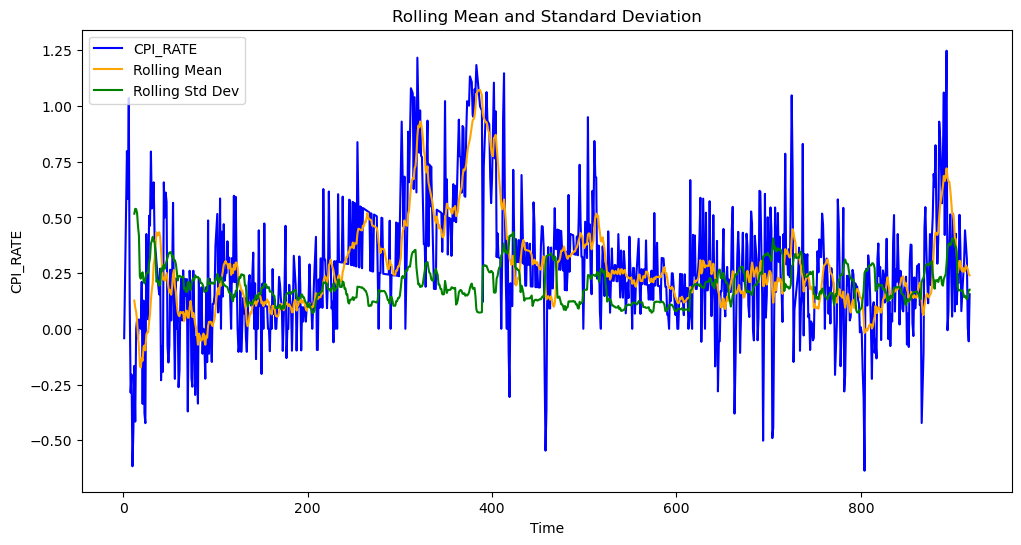

In [119]:
# Calculate rolling mean and std
window_size = 12 
rolling_mean = y.rolling(window=window_size).mean()
rolling_std = y.rolling(window=window_size).std()

plt.figure(figsize=(12, 6))
plt.plot(y, label='CPI_RATE', color='blue')
plt.plot(rolling_mean, label='Rolling Mean', color='orange')
plt.plot(rolling_std, label='Rolling Std Dev', color='green')
plt.title('Rolling Mean and Standard Deviation')
plt.legend()
plt.xlabel('Time')
plt.ylabel('CPI_RATE')
plt.show()


In [121]:
adl_11_data = pd.DataFrame({'y': y, 'X_lag1': X.shift(1)}).dropna()
adl_11 = AutoReg(adl_11_data['y'], lags=1, exog=adl_11_data['X_lag1']).fit()
print(adl_11.summary())

#select optimal lag length for ADL(p,p) model using BIC
bic_adl_values = []
for lag in range(1, 5):
    adl_data = pd.DataFrame({'y': y, 'X_lag': X.shift(lag)}).dropna()
    model_adl = AutoReg(adl_data['y'], lags=lag, exog=adl_data['X_lag']).fit()
    bic_adl_values.append(model_adl.bic)

optimal_adl_lag = bic_adl_values.index(min(bic_adl_values)) + 1
print("BIC values for ADL(1,1) to ADL(4,4):", bic_adl_values)
print("Optimal ADL lag length:", optimal_adl_lag)

#granger causality test
granger_data = merged_df[['CPI_RATE', 'UNRATE']].dropna()
granger_result = grangercausalitytests(granger_data, maxlag=optimal_adl_lag)

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  917
Model:                   AutoReg-X(1)   Log Likelihood                  53.232
Method:               Conditional MLE   S.D. of innovations              0.228
Date:                Sat, 02 Nov 2024   AIC                            -98.464
Time:                        16:54:12   BIC                            -79.184
Sample:                             1   HQIC                           -91.105
                                  917                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0730      0.027      2.712      0.007       0.020       0.126
y.L1           0.6233      0.026     24.151      0.000       0.573       0.674
X_lag1         0.0057      0.004      1.291      0.1

c:\Users\jakub\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jakub\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jakub\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jakub\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jakub\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self.

In [122]:
adl_44_data = pd.DataFrame({'y': y, 'X_lag4': X.shift(4)}).dropna()
adl_44 = AutoReg(adl_44_data['y'], lags=4, exog=adl_44_data['X_lag4']).fit()
adl_44_summary = adl_44.summary()
 
print(adl_44_summary)


                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  914
Model:                   AutoReg-X(4)   Log Likelihood                  92.142
Method:               Conditional MLE   S.D. of innovations              0.219
Date:                Sat, 02 Nov 2024   AIC                           -170.285
Time:                        16:54:12   BIC                           -136.590
Sample:                             4   HQIC                          -157.420
                                  914                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0431      0.026      1.650      0.099      -0.008       0.094
y.L1           0.4820      0.033     14.745      0.000       0.418       0.546
y.L2           0.0693      0.036      1.910      0.0

c:\Users\jakub\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [123]:
from sklearn.metrics import mean_squared_error
import numpy as np

#define the pseudo out-of-sample cutoff (last 25% of data)
cutoff = int(len(y) * 0.75)
train_y, test_y = y[:cutoff], y[cutoff:]
train_X, test_X = X[:cutoff].shift(1), X[cutoff:].shift(1)

train_data = pd.DataFrame({'y': train_y, 'X': train_X}).dropna()
test_data = pd.DataFrame({'y': test_y, 'X': test_X}).dropna()

#fit the ADL(1,1) model on training data
adl_11_train = AutoReg(train_data['y'], lags=1, exog=train_data['X']).fit()

#align train data with fitted values to ensure equal lengths for SER calculation
aligned_train_y = train_data['y'][-len(adl_11_train.fittedvalues):]

#forecast the test set and calculate SER and RMSFE
forecast = adl_11_train.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, exog_oos=test_data['X'])
ser = np.sqrt(mean_squared_error(aligned_train_y, adl_11_train.fittedvalues))
rmsfe = np.sqrt(mean_squared_error(test_data['y'], forecast))

print("Within-sample SER:", ser)
print("Out-of-sample RMSFE:", rmsfe)
print("RMSFE vs. SER comparison:", "RMSFE is larger" if rmsfe > ser else "SER is larger or equal")


Within-sample SER: 0.22242969975399646
Out-of-sample RMSFE: 0.2919870337312882
RMSFE vs. SER comparison: RMSFE is larger


c:\Users\jakub\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jakub\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\jakub\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
